# Pair Trading (Statistical Arbitrage) — KO / PEP

This notebook implements a **cointegration-based pair trading strategy** on **Coca-Cola (KO)** and **PepsiCo (PEP)**.

**Key steps**
1. Download data (daily, adjusted)
2. Work on log-prices
3. Rolling OLS hedge ratio estimation
4. Build spread and z-score
5. Generate trading signals (entry/exit)
6. Compute PnL with transaction costs
7. Evaluate performance + plots

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

In [5]:
# -----------------------------
# Parameters
# -----------------------------
PARAMS = {
    "y_ticker": "KO",
    "x_ticker": "PEP",
    "start": "2022-01-01",
    "end":   "2026-01-01",
    "lookback_beta": 252,   # rolling OLS window
    "lookback_z": 60,       # rolling z-score window
    "entry_z": 2.5,
    "exit_z": 0.5,
    "tc_bps": 0.5,          # transaction cost per leg (bps)
    "capital": 1.0,
    "ann_factor": 252
}

In [6]:
def download_prices(tickers, start, end):
    """
    Download daily adjusted close prices using yfinance.
    Returns a DataFrame of Close prices (auto-adjusted).
    """
    px = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"].dropna()
    if isinstance(px, pd.Series):
        px = px.to_frame()
    return px

def rolling_beta_ols(Y_log, X_log, window):
    """
    Rolling OLS: Y = alpha + beta * X
    Returns a Series of betas aligned with index.
    """
    betas = np.full(len(Y_log), np.nan, dtype=float)

    for i in range(window, len(Y_log)):
        y = Y_log.iloc[i-window:i]
        x = X_log.iloc[i-window:i]
        X_design = sm.add_constant(x)  # alpha + beta*X
        model = sm.OLS(y, X_design).fit()
        betas[i] = model.params[x.name]

    return pd.Series(betas, index=Y_log.index, name="beta")

def compute_spread_zscore(Y_log, X_log, beta, lookback_z):
    """
    Spread: S = log(Y) - beta * log(X)
    Z-score computed with rolling mean/std on the spread.
    """
    spread = (Y_log - beta * X_log).rename("spread")
    m = spread.rolling(lookback_z).mean()
    s = spread.rolling(lookback_z).std(ddof=0)
    z = ((spread - m) / s).rename("z")
    return spread, z

def generate_positions(z, beta, entry_z, exit_z):
    """
    State-machine positions:
    - enter short spread when z > entry
    - enter long spread when z < -entry
    - exit when |z| < exit
    Position definition:
      pos = +1  => long spread (long Y, short beta*X)
      pos = -1  => short spread (short Y, long beta*X)
    """
    pos = pd.Series(0.0, index=z.index, name="pos")
    valid = beta.notna() & z.notna() & np.isfinite(z)

    pos.loc[valid & (z > entry_z)] = -1.0
    pos.loc[valid & (z < -entry_z)] = +1.0

    # hold until exit
    pos = pos.replace(0, np.nan).ffill().fillna(0.0)
    pos.loc[valid & (np.abs(z) < exit_z)] = 0.0
    pos = pos.ffill().fillna(0.0)

    return pos

def backtest_pair(px_y, px_x, beta, pos, tc_bps):
    """
    Computes daily strategy returns:
      r = pos_{t-1} * (rY - beta_{t-1} * rX) / (1 + |beta_{t-1}|)
    Applies transaction costs: turnover * 2 legs * tc_bps.
    Returns a DataFrame with components.
    """
    retY = px_y.pct_change()
    retX = px_x.pct_change()

    beta_lag = beta.shift(1)
    pos_lag = pos.shift(1)

    gross = 1.0 + beta_lag.abs()
    raw_ret = pos_lag * (retY - beta_lag * retX) / gross
    raw_ret = raw_ret.fillna(0.0)

    turnover = pos.diff().abs().fillna(0.0)
    tc = turnover * (2.0 * tc_bps / 1e4)

    net_ret = raw_ret - tc

    out = pd.DataFrame({
        "retY": retY,
        "retX": retX,
        "beta": beta,
        "pos": pos,
        "raw_ret": raw_ret,
        "tc": tc,
        "net_ret": net_ret
    })
    return out

def performance_stats(net_ret, equity, ann_factor=252):
    """
    Returns Sharpe, CAGR, Max Drawdown.
    """
    mu = net_ret.mean()
    sigma = net_ret.std(ddof=0)
    sharpe = (mu / (sigma + 1e-12)) * np.sqrt(ann_factor)

    years = len(equity) / ann_factor
    cagr = equity.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan

    max_dd = (equity / equity.cummax() - 1.0).min()

    return {"sharpe": sharpe, "cagr": cagr, "max_dd": max_dd}

In [7]:
y_ticker = PARAMS["y_ticker"]
x_ticker = PARAMS["x_ticker"]

px = download_prices([y_ticker, x_ticker], PARAMS["start"], PARAMS["end"])
px.head()

[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Date,,
2022-01-03,52.627056,152.591629
2022-01-04,53.505653,152.812164
2022-01-05,53.949387,153.332611
2022-01-06,53.665401,153.367889
2022-01-07,53.541161,153.561966


In [8]:
Y_log = np.log(px[y_ticker]).rename("Y")
X_log = np.log(px[x_ticker]).rename("X")

score, pvalue, _ = coint(Y_log, X_log)
print(f"Cointegration p-value (log-prices): {pvalue:.4f}")

Cointegration p-value (log-prices): 0.1659


In [9]:
beta = rolling_beta_ols(Y_log, X_log, PARAMS["lookback_beta"])
spread, z = compute_spread_zscore(Y_log, X_log, beta, PARAMS["lookback_z"])

display(pd.concat([beta, spread, z], axis=1).tail())

,beta,spread,z
Date,,,
2025-12-24,-0.138080,4.936050,-2.374934
2025-12-26,-0.129773,4.891383,-2.332022
2025-12-29,-0.122764,4.861095,-2.262477
2025-12-30,-0.114403,4.818186,-2.217585
2025-12-31,-0.106120,4.774253,-2.174803


In [10]:
pos = generate_positions(z, beta, PARAMS["entry_z"], PARAMS["exit_z"])
pos.value_counts().sort_index()

pos
-1.0     74
 0.0    680
 1.0    249
Name: count, dtype: int64

In [11]:
bt = backtest_pair(
    px_y=px[y_ticker],
    px_x=px[x_ticker],
    beta=beta,
    pos=pos,
    tc_bps=PARAMS["tc_bps"]
)

equity = (1.0 + bt["net_ret"]).cumprod() * PARAMS["capital"]
stats = performance_stats(bt["net_ret"], equity, PARAMS["ann_factor"])

print(f"Sharpe: {stats['sharpe']:.2f}")
print(f"CAGR:   {stats['cagr']:.2%}")
print(f"MaxDD:  {stats['max_dd']:.2%}")

Sharpe: 0.36
CAGR:   2.51%
MaxDD:  -10.53%


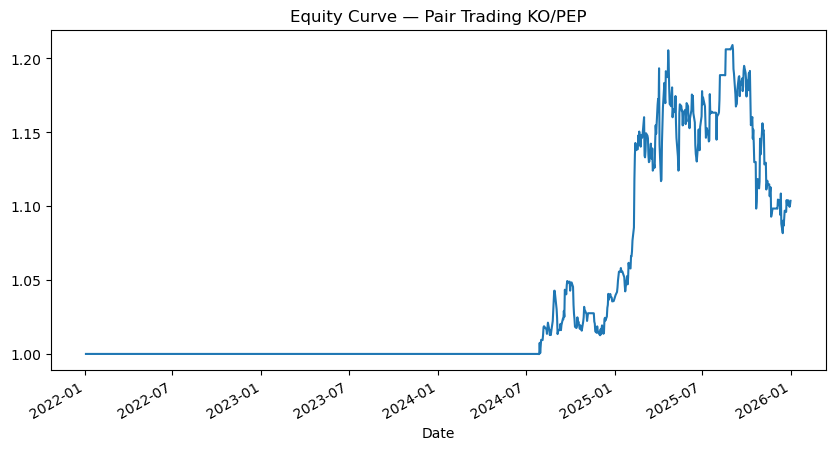

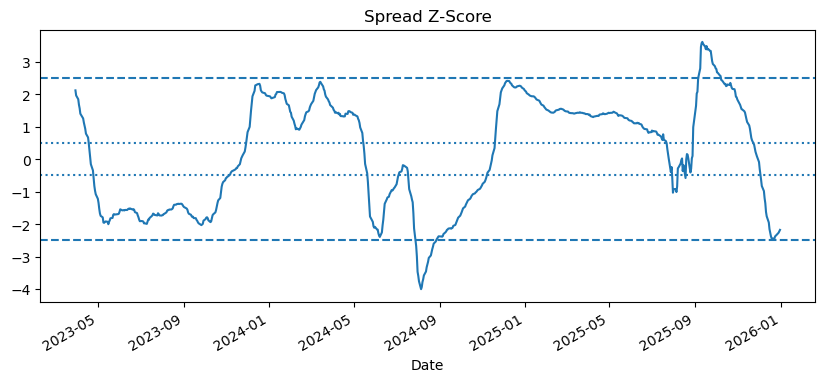

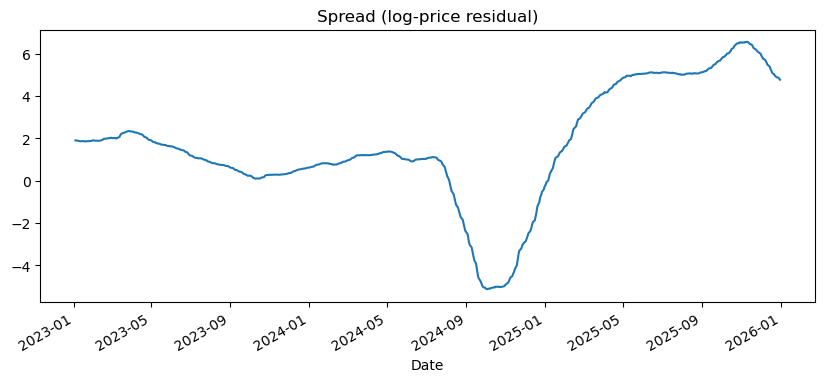

In [12]:
plt.figure(figsize=(10, 5))
equity.plot(title=f"Equity Curve — Pair Trading {y_ticker}/{x_ticker}")
plt.show()

plt.figure(figsize=(10, 4))
z.plot(title="Spread Z-Score")
plt.axhline(PARAMS["entry_z"], linestyle="--")
plt.axhline(-PARAMS["entry_z"], linestyle="--")
plt.axhline(PARAMS["exit_z"], linestyle=":")
plt.axhline(-PARAMS["exit_z"], linestyle=":")
plt.show()

plt.figure(figsize=(10, 4))
spread.plot(title="Spread (log-price residual)")
plt.show()

## How to interpret trades

We trade the spread:

- If **z > entry**, the spread is high → **short spread**  
  → **short KO**, **long PEP (scaled by β)**

- If **z < -entry**, the spread is low → **long spread**  
  → **long KO**, **short PEP (scaled by β)**

Positions are closed when **|z| < exit**.
